In [1]:
import numpy as np
import PyPDF2
import docx2txt
import sys

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
import networkx as nx

In [4]:
import numpy as np
import scipy.sparse as sparse
import time
import pickle
from igraph import *
from dataset_fetcher import ListToMatrixConverter
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import time

In [5]:
from nltk.tokenize.punkt import PunktSentenceTokenizer

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [7]:
from __future__ import print_function
from pythonrouge.pythonrouge import Pythonrouge
from pprint import pprint

In [8]:
def readDoc():
    name = input('Please input a file name: ') 
    print('You have asked for the document {}'.format(name))

    if name.lower().endswith('.txt'):
        choice = 1
    elif name.lower().endswith('.pdf'):
        choice = 2
    else:
        choice = 3
    print(choice)
   
    if choice == 1:
        f = open(name, 'r')
        document = f.read()
        f.close()
            
    elif choice == 2:
        pdfFileObj = open(name, 'rb')
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        pageObj = pdfReader.getPage(0)
        document = pageObj.extractText()
        pdfFileObj.close()
    
    else:
        print('Failed to load a valid file')
        print('Returning an empty string')
        document = ''
    
    print(type(document))
    return document

In [9]:
def tokenize(document):
    doc_tokenizer = PunktSentenceTokenizer()

    sentences_list = doc_tokenizer.tokenize(document)
    return sentences_list

In [10]:
document = readDoc()
print('The length of the file is:', end=' ')
print(len(document))

Please input a file name: story4.txt
You have asked for the document story4.txt
1
<class 'str'>
The length of the file is: 6425


In [11]:
sentences_list = tokenize(document)
print('The size of the list in Bytes is: {}'.format(sys.getsizeof(sentences_list)))
print('The size of the item 0 in Bytes is: {}'.format(sys.getsizeof(sentences_list[0])))

The size of the list in Bytes is: 408
The size of the item 0 in Bytes is: 682


In [12]:
print(type(sentences_list))

<class 'list'>


In [13]:
print('The size of the list "sentences" is: {}'.format(len(sentences_list)))

The size of the list "sentences" is: 33


In [14]:
for i in sentences_list:
    print(i)

Introduction

Cesarean section (CS), although essential and lifesaving with the correct indication, is largely unnecessary in nonemergency conditions, leading to greater financial costs relative to vaginal delivery, without proven benefit, and increasing risks for maternal morbidity and mortality [1–8].
In addition, CS has been associated with elevated risks of adverse maternal and perinatal outcomes in future pregnancies, including maternal and intra-uterine fetal death [9–13].
Since 1985, the World Health Organization (WHO) has recommended that national CS rates not exceed 10% to 15% [14].
A statement issued in 2016 further strengthened WHO’s position, with evidence suggesting that population-level CS rates higher than 10% are not associated with reduced maternal and neonatal mortality [15].
Contrary to the recommendation, the rate of cesarean delivery has been rising sharply in the last two decades worldwide [16,17].
A study of 194 WHO member states estimated global cesarean deliver

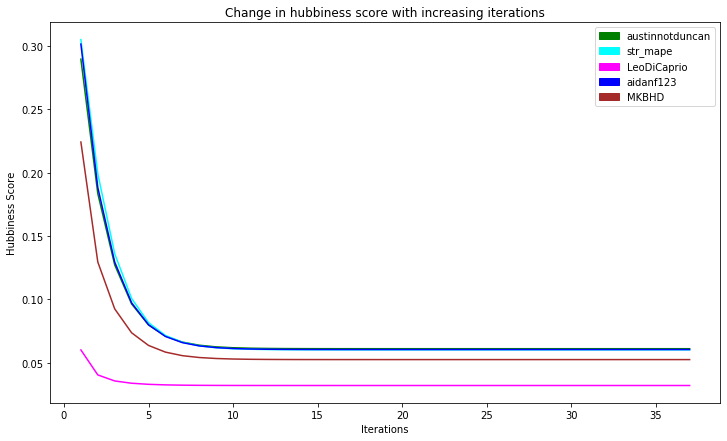

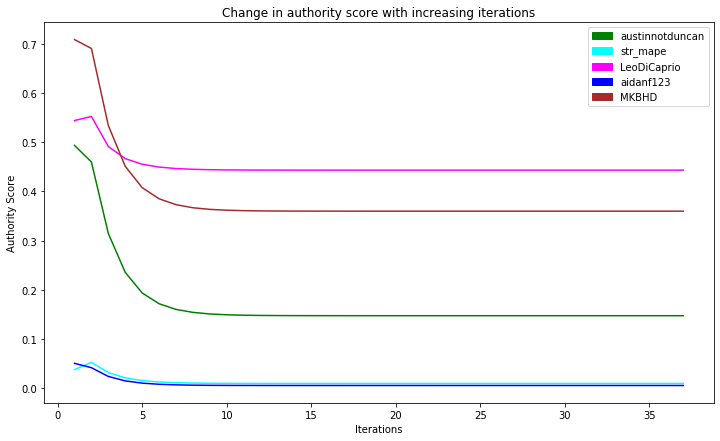

In [15]:

debug = False

class HITS():
	def __init__(self, link_matrix, users, index_id_map, is_sparse=False):
		self.__is_sparse = is_sparse
		self.__link_matrix = link_matrix
		self.__link_matrix_tr = link_matrix.transpose()	
		self.__n = self.__link_matrix.shape[0]
		self.__hubs = np.ones(self.__n)
		self.__auths = np.ones(self.__n)
		self.__size = 30
		self.__names = [users[index_id_map[i]]['screen_name'] for i in range(0,self.__size)]
		self.__index_id_map = index_id_map
		self.__users = users
		self.all_hubs = []
		self.all_auths = []

	def calc_scores(self, epsilon=1e-4):
		epsilon_matrix = epsilon * np.ones(self.__n)
		if self.__is_sparse:			
			while True:
				hubs_old = self.__hubs
				auths_old = self.__auths

				self.__auths = self.__link_matrix_tr * hubs_old
				max_score = self.__auths.max(axis=0)
				if max_score != 0:
					self.__auths = self.__auths / max_score
				self.all_auths.append(self.__auths)

				self.__hubs = self.__link_matrix * self.__auths
				max_score = self.__hubs.max(axis=0)
				if max_score != 0:
					self.__hubs = self.__hubs / max_score
				self.all_hubs.append(self.__hubs)

				if (((abs(self.__hubs - hubs_old)) < epsilon_matrix).all()) and (((abs(self.__auths - auths_old)) < epsilon_matrix).all()):
					break

		else:
			while True:
				hubs_old = self.__hubs
				auths_old = self.__auths

				self.__auths = np.dot(self.__link_matrix_tr, hubs_old)
				max_score = self.__auths.max(axis=0)
				if max_score != 0:
					self.__auths = self.__auths / max_score
				self.all_auths.append(self.__auths)

				self.__hubs = np.dot(self.__link_matrix, self.__auths)
				max_score = self.__hubs.max(axis=0)
				if max_score != 0:
					self.__hubs = self.__hubs / max_score
				self.all_hubs.append(self.__hubs)

				if (((abs(self.__hubs - hubs_old)) < epsilon_matrix).all()) and (((abs(self.__auths - auths_old)) < epsilon_matrix).all()):
					break

	def get_all_hubs(self):
		return self.all_hubs

	def get_all_auths(self):
		return self.all_auths

	def get_hubs(self):
		return self.__hubs

	def get_auths(self):
		return self.__auths

	def get_names(self):
		return self.__names

	def plot_graph(self, x, names, c):
		if self.__is_sparse:
			g = Graph.Adjacency((self.__link_matrix[0:self.__size, 0:self.__size]).toarray().tolist())
		else:
			g = Graph.Adjacency((self.__link_matrix[0:self.__size, 0:self.__size]).tolist())
		g.vs["name"] = names
		g.vs["attr"] = ["%.3f" % k for k in x]

		array_min = 0
		if x.min(axis=0) < 0.001:
			array_min = 0.001
		else:
			array_min = x.min(axis=0)
		layout = g.layout("kk")
		visual_style = {}
		visual_style["vertex_size"] = [(x[i]/array_min)*0.3 if x[i]>=0.001 else 10 for i in range(0,min(self.__size,len(x)))]
		visual_style["vertex_label"] = [(g.vs["name"][i],float(g.vs["attr"][i])) for i in range(0,min(self.__size,len(x)))]
		color_dict = {"0":"red" , "1":"yellow"}
		g.vs["color"] = color_dict[str(c)]
		visual_style["edge_arrow_size"]=2
		visual_style["vertex_label_size"]=35
		visual_style["layout"] = layout
		visual_style["bbox"] = (3200, 2200)
		visual_style["margin"] = 250
		visual_style["edge_width"] = 4
		plot(g, **visual_style)

	def plot_stats(self):
		screen_name_index_map = {}
		for key in self.__index_id_map:
			screen_name_index_map[self.__users[self.__index_id_map[key]]['screen_name']] = key
		
		cands = ['austinnotduncan', 'str_mape', 'LeoDiCaprio', 'aidanf123', 'MKBHD']
		colors = ['green', 'cyan', 'magenta', 'blue', 'brown']
		all_hubs = np.array(self.all_hubs)
		all_auths = np.array(self.all_auths)

		plt.figure(1, figsize=(12, 7))
		ax = plt.gca()
		ax.set_xlabel("Iterations")
		ax.set_ylabel("Hubbiness Score")
		legend_handles = []
		for i in range(len(cands)):
			legend_handles.append(mp.Patch(label=cands[i], color=colors[i]))
			ax.plot(np.arange(1, all_hubs.shape[0] + 1), all_hubs[:, screen_name_index_map[cands[i]]], color=colors[i])
		ax.legend(handles=legend_handles)
		ax.set_title("Change in hubbiness score with increasing iterations")
		plt.show()

		plt.figure(2, figsize=(12, 7))
		ax = plt.gca()
		ax.set_xlabel("Iterations")
		ax.set_ylabel("Authority Score")
		legend_handles = []
		for i in range(len(cands)):
			legend_handles.append(mp.Patch(label=cands[i], color=colors[i]))
			ax.plot(np.arange(1, all_auths.shape[0] + 1), all_auths[:, screen_name_index_map[cands[i]]], color=colors[i])
		ax.legend(handles=legend_handles)
		ax.set_title("Change in authority score with increasing iterations")
		plt.show()

class DatasetReader():
	def __init__(self):
		pass

	def read_users(self, users_path):
		with open(users_path, mode='rb') as f:
			users = pickle.load(f)
		return users

	def read_map(self, map_path):
		with open(map_path, mode='rb') as f:
			index_id_map = pickle.load(f)
		return index_id_map

	def read_link_matrix(self, link_matrix_path, is_sparse=False):
		with open(link_matrix_path, mode='rb') as f:
			if is_sparse:
				link_matrix = sparse.load_npz(link_matrix_path)
			else:
				link_matrix = np.load(f)
		return link_matrix


def main():
	sparse = True
	epsilon = 1e-10
	show_iters = False

	users_path = '../data/users'
	map_path = '../data/map'
	sparse_link_matrix_path = '../data/sparse_link_matrix'
	dense_link_matrix_path = '../data/dense_link_matrix'
	if sparse:
		link_matrix_path = sparse_link_matrix_path
	else:
		link_matrix_path = dense_link_matrix_path
	r = DatasetReader()
	users = r.read_users(users_path)
	index_id_map = r.read_map(map_path)
	link_matrix = r.read_link_matrix(link_matrix_path, is_sparse=sparse)

	# Run the algorithm
	h = HITS(link_matrix, users, index_id_map, is_sparse=sparse)
	h.calc_scores(epsilon=epsilon)
	
	if show_iters:
		x = h.get_all_hubs()
		for i in x:
			h.plot_graph(i, h.get_names(),0)

		y = h.get_all_auths()
		for i in y:
			h.plot_graph(i, h.get_names(),1)
	else:
		h.plot_graph(h.get_hubs(), h.get_names(),0)
		h.plot_graph(h.get_auths(), h.get_names(),1)
	
	h.plot_stats()

if __name__ == '__main__':
	main()

In [16]:
cv = CountVectorizer()
cv_matrix = cv.fit_transform(sentences_list)

In [17]:
cv_demo = CountVectorizer()
text_demo = ["Goutham is good, you are bad", "I am not bad"] 
res_demo = cv_demo.fit_transform(text_demo)
print('Result demo array is {}'.format(res_demo.toarray()))
print('Feature list: {}'.format(cv_demo.get_feature_names()))

Result demo array is [[0 1 1 1 1 1 0 1]
 [1 0 1 0 0 0 1 0]]
Feature list: ['am', 'are', 'bad', 'good', 'goutham', 'is', 'not', 'you']


In [18]:
print('The data type of bow matrix {}'.format(type(cv_matrix)))
print('Shape of the matrix {}'.format(cv_matrix.get_shape))
print('Size of the matrix is: {}'.format(sys.getsizeof(cv_matrix)))
print(cv.get_feature_names())
print(cv_matrix.toarray())

The data type of bow matrix <class 'scipy.sparse.csr.csr_matrix'>
Shape of the matrix <bound method spmatrix.get_shape of <33x409 sparse matrix of type '<class 'numpy.int64'>'
	with 838 stored elements in Compressed Sparse Row format>>
Size of the matrix is: 56
['000', '10', '12', '13', '14', '15', '16', '17', '18', '19', '194', '1985', '20', '2001', '2008', '2010', '2012', '2014', '2016', '22', '23', '24', '28', '30', '300', '31', '34', '40', '41', '438', '45', '865', 'about', 'action', 'addition', 'adjustments', 'advanced', 'advantages', 'adverse', 'agencies', 'aim', 'aimed', 'aiming', 'all', 'allocated', 'also', 'although', 'among', 'an', 'analysis', 'and', 'annual', 'appointed', 'approaches', 'appropriate', 'approved', 'are', 'areas', 'as', 'assessment', 'associated', 'assurance', 'average', 'awareness', 'baby', 'based', 'be', 'because', 'been', 'before', 'began', 'beliefs', 'benefit', 'between', 'birth', 'births', 'board', 'building', 'by', 'campaign', 'capacity', 'care', 'carried

In [19]:
normal_matrix = TfidfTransformer().fit_transform(cv_matrix)
print(normal_matrix.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.25426631 0.         ... 0.         0.28434324 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [20]:
print(normal_matrix.T.toarray)
res_graph = normal_matrix * normal_matrix.T
# plt.spy(res_graph)

<bound method _cs_matrix.toarray of <409x33 sparse matrix of type '<class 'numpy.float64'>'
	with 838 stored elements in Compressed Sparse Column format>>


/home/goutham/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Number of edges 556
Number of vertices 33


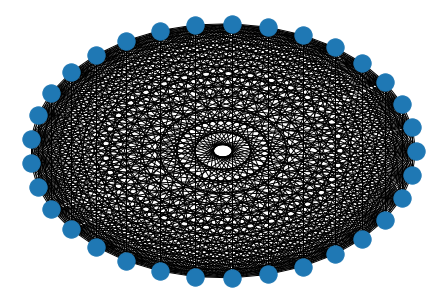

The memory used by the graph in Bytes is: 56


In [21]:
nx_graph = nx.from_scipy_sparse_matrix(res_graph)
nx.draw_circular(nx_graph)
print('Number of edges {}'.format(nx_graph.number_of_edges()))
print('Number of vertices {}'.format(nx_graph.number_of_nodes()))
plt.show()
print('The memory used by the graph in Bytes is: {}'.format(sys.getsizeof(nx_graph)))

In [22]:
ranks = nx.pagerank(nx_graph)
print(type(ranks))
print('The size used by the dictionary in Bytes is: {}'.format(sys.getsizeof(ranks)))
for i in ranks:
    print(i, ranks[i])


<class 'dict'>
The size used by the dictionary in Bytes is: 1184
0 0.02792905133357305
1 0.027206895658705828
2 0.024335018729158796
3 0.025692542295781325
4 0.027823307496692706
5 0.022454056012734744
6 0.02790588384444488
7 0.029860953696199368
8 0.03591016582653885
9 0.03690782483689465
10 0.023965568381554437
11 0.03210461603349437
12 0.03304985178581262
13 0.03516557949238897
14 0.043813135227519166
15 0.036882467909121565
16 0.03643888192453008
17 0.034985207810723715
18 0.029068951948520213
19 0.023820574132374785
20 0.023142154032323007
21 0.04388603061296163
22 0.02308171521529565
23 0.02815869724738364
24 0.029136060890557924
25 0.03107945732228093
26 0.026575877124759548
27 0.031024409945693582
28 0.03479111946156298
29 0.030858501916610964
30 0.02565180906138397
31 0.026425082195799424
32 0.030868550596622746


In [23]:
sentence_array = sorted(((ranks[i], s) for i, s in enumerate(sentences_list)), reverse=True)
sentence_array = np.asarray(sentence_array)

In [24]:
rank_max = float(sentence_array[0][0])
rank_min = float(sentence_array[len(sentence_array) - 1][0])

In [25]:
print(rank_max)
print(rank_min)

0.04388603061296163
0.022454056012734744


In [26]:
temp_array = []
flag = 0
if rank_max - rank_min == 0:
    temp_array.append(0)
    flag = 1
if flag != 1:
    for i in range(0, len(sentence_array)):
        temp_array.append((float(sentence_array[i][0]) - rank_min) / (rank_max - rank_min))

print(len(temp_array))

33


In [27]:
threshold = (sum(temp_array) / len(temp_array)) + 0.2

In [28]:
sentence_list = []
if len(temp_array) > 1:
    for i in range(0, len(temp_array)):
        if temp_array[i] > threshold:
                sentence_list.append(sentence_array[i][1])
else:
    sentence_list.append(sentence_array[0][1])

In [29]:
model = sentence_list

In [30]:
summary = " ".join(str(x) for x in sentence_list)
print(summary)
f = open('final3.txt', 'a+')
f.write('\n')
f.write(summary)
f.close

Design and implementation of the two-stage intervention package

The intervention was part of a large-scale municipality-wide maternal and neonatal health promotion program, the Action Plan for Safe Motherhood and Infancy, with the overall aim to reduce maternal and neonatal mortality in Guangzhou. As an integral component of this plan, an intervention package intended to reduce CS rate was implemented in 2 stages (October 2010 to September 2014 and October 2014 to December 2016) and comprised programs for population health education, skills training to healthcare professionals, equipment and technical support for local healthcare facilities, and capacity building for the maternal near-miss care system. The risk for adverse outcomes has prompted the Health Commission of Guangzhou Municipality to investigate strategies to reduce CS rates and to improve the quality of intrapartum care [18]. Using routine surveillance data between January 1, 2008, and December 31, 2016, the present study 

<function TextIOWrapper.close()>

In [31]:
for lines in sentence_list:
    print(lines)

Design and implementation of the two-stage intervention package

The intervention was part of a large-scale municipality-wide maternal and neonatal health promotion program, the Action Plan for Safe Motherhood and Infancy, with the overall aim to reduce maternal and neonatal mortality in Guangzhou.
As an integral component of this plan, an intervention package intended to reduce CS rate was implemented in 2 stages (October 2010 to September 2014 and October 2014 to December 2016) and comprised programs for population health education, skills training to healthcare professionals, equipment and technical support for local healthcare facilities, and capacity building for the maternal near-miss care system.
The risk for adverse outcomes has prompted the Health Commission of Guangzhou Municipality to investigate strategies to reduce CS rates and to improve the quality of intrapartum care [18].
Using routine surveillance data between January 1, 2008, and December 31, 2016, the present study 

In [32]:

if __name__ == '__main__':
    reference = './sample/reference/plos2.txt'
    print('evaluate sumamry & reference in these dirs')
    print('summary:\t{}\nreference:\t{}'.format(summary, reference))
    rouge = Pythonrouge(summary_file_exist=True,
                        peer_path=summary, model_path=reference,
                        n_gram=2, ROUGE_SU4=True, ROUGE_L=False,
                        recall_only=False, f_measure_only=False,
                        stemming=True, stopwords=True,
                        word_level=True, length_limit=True, length=50,
                        use_cf=True, cf=95, scoring_formula='average',
                        resampling=True, samples=1000, favor=True, p=0.5)
    score = rouge.calc_score()
    print('ROUGE-N(1-2) & SU4 recall & f-measure with confidence interval')
    pprint(score)
    print('Evaluate ROUGE based on sentecnce lists')
    """
    ROUGE evaluates all system summaries and its corresponding reference
    a summary or summaries at onece.
    Summary should be double list, in each list has each summary.
    Reference summaries should be triple list because some of reference
    has multiple gold summaries.
    """
    summary = [["Design and implementation of the two-stage intervention package",
                "As an integral component of this plan, an intervention package intended to reduce CS rate was implemented\
                in 2 stages (October 2010 to September 2014 and October 2014 to December 2016)",
                "The risk for adverse outcomes has prompted the Health Commission of Guangzhou Municipality to investigate\
                strategies to reduce CS rates and to improve the quality of intrapartum care"],
               ["Using routine surveillance data between January 1, 2008, and December 31, 2016, the present study aimed\
               to evaluate changes of the overall CS rate in Guangzhou over the period of the two-stage intervention",
                "In Guangzhou, the third largest city in China with a population of 14 million and 300,000 annual births,\
                the CS rate was about 40% between 2001 and 2010, far higher than the national average and the level recommended by WHO.",
                "This is a repeated cross-sectional study aiming to retrospectively evaluate a two-stage intervention package implemented by the municipal government to reduce the overall CS rate in Guangzhou."]]
    reference = [
                 [["The risk for adverse outcomes has prompted the Health Commission of Guangzhou Municipality to investigate strategies to reduce CS rates and to improve the quality of intrapartum care."],
                  [" It was implemented by the government of Guangzhou, China, from October 2010 to December 2016 to control the CS rate in the city., and intrinsic cultural beliefs popular among Chinese families."],
                  ["As an integral component of this plan, an intervention package intended to reduce CS rate was implemented in 2 stages (October 2010 to September 2014 and October 2014 to December 2016).",
                  "Using routine surveillance data between January 1, 2008, and December 31, 2016, the present study aimed to evaluate changes."]],
                 [["Trends in maternal and perinatal mortality were also examined to evaluate the safety of the intervention package when reducing the CS rate.",
                   "The conduct of this study was fully compliant with relevant national regulations and was approved by the institutional ethical committee board."],
                  ["This study is reported as per the REporting of studies Conducted using Observational Routinely-collected health Data (RECORD) guideline.",
                   " Given the lack of comparable groups and the temporal change in the study population, the contribution of this intervention package should be interpreted with caution.",
                   "The intervention was part of a large-scale municipality-wide maternal and neonatal health promotion program, the Action Plan for Safe Motherhood and Infancy."],
                  ["Before the intervention began, detailed documentation on the contents, requirements, targets, timeline, responsibilities, funding, supervision.",
                  "There were 3 elements in Stage 1 (October 1, 2010, to September 30, 2014): health education, skills training, and capacity building."],
                  ["Also as part of the publicity campaign, they held roadshows in the community with posters and videos and handed out information leaflets.",
                  "Towards the end of Stage 1, an interim evaluation and a comprehensive needs assessment for the public, for healthcare institutions, and for public health agencies were conducted."]]
                  ]
    rouge = Pythonrouge(summary_file_exist=False,
                        summary=summary, reference=reference,
                        n_gram=2, ROUGE_SU4=True, ROUGE_L=False,
                        recall_only=True, stemming=True, stopwords=True,
                        word_level=True, length_limit=True, length=50,
                        use_cf=True, cf=95, scoring_formula='average',
                        resampling=True, samples=1000, favor=True, p=0.5)
    score = rouge.calc_score()
    print('ROUGE-N(1-2) & SU4 recall only with confidence interval')
    pprint(score)

evaluate sumamry & reference in these dirs
summary:	Design and implementation of the two-stage intervention package

The intervention was part of a large-scale municipality-wide maternal and neonatal health promotion program, the Action Plan for Safe Motherhood and Infancy, with the overall aim to reduce maternal and neonatal mortality in Guangzhou. As an integral component of this plan, an intervention package intended to reduce CS rate was implemented in 2 stages (October 2010 to September 2014 and October 2014 to December 2016) and comprised programs for population health education, skills training to healthcare professionals, equipment and technical support for local healthcare facilities, and capacity building for the maternal near-miss care system. The risk for adverse outcomes has prompted the Health Commission of Guangzhou Municipality to investigate strategies to reduce CS rates and to improve the quality of intrapartum care [18]. Using routine surveillance data between Januar